In [1]:
import torch
from model import ODEBlock, MLP
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

/home/npg5/anaconda3/envs/hnn/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load model and dataset
t = torch.load("./data/t.pth")
X = torch.load("./data/X.pth")
dX = torch.load("./data/dX.pth")
dim = X.shape[-1]
model_ode= ODEBlock(dim,1000,dim)
model_mlp = MLP(dim,1000,dim)
model_mlp.eval()
model_ode.load_state_dict(torch.load("result/model/ODEBlock.pth"))
model_mlp.load_state_dict(torch.load("result/model/MLP.pth"))

<All keys matched successfully>

In [3]:
def getTestdata(X, FaultDuration = 30):
    if FaultDuration<30 or FaultDuration > 500:
        raise ValueError("Fault Duration out of range.")
    return X[FaultDuration - 30]

In [4]:
# Evaluation

FaultDuration = 125
t_trunc = 6
x_test = getTestdata(X, FaultDuration=FaultDuration)
x0_test = x_test[0]

In [5]:
x_test_hat_ode =odeint(model_ode, x0_test, t, method='dopri5').detach()
x_test_hat_mlp =odeint(model_mlp, x0_test, t, method='dopri5').detach()

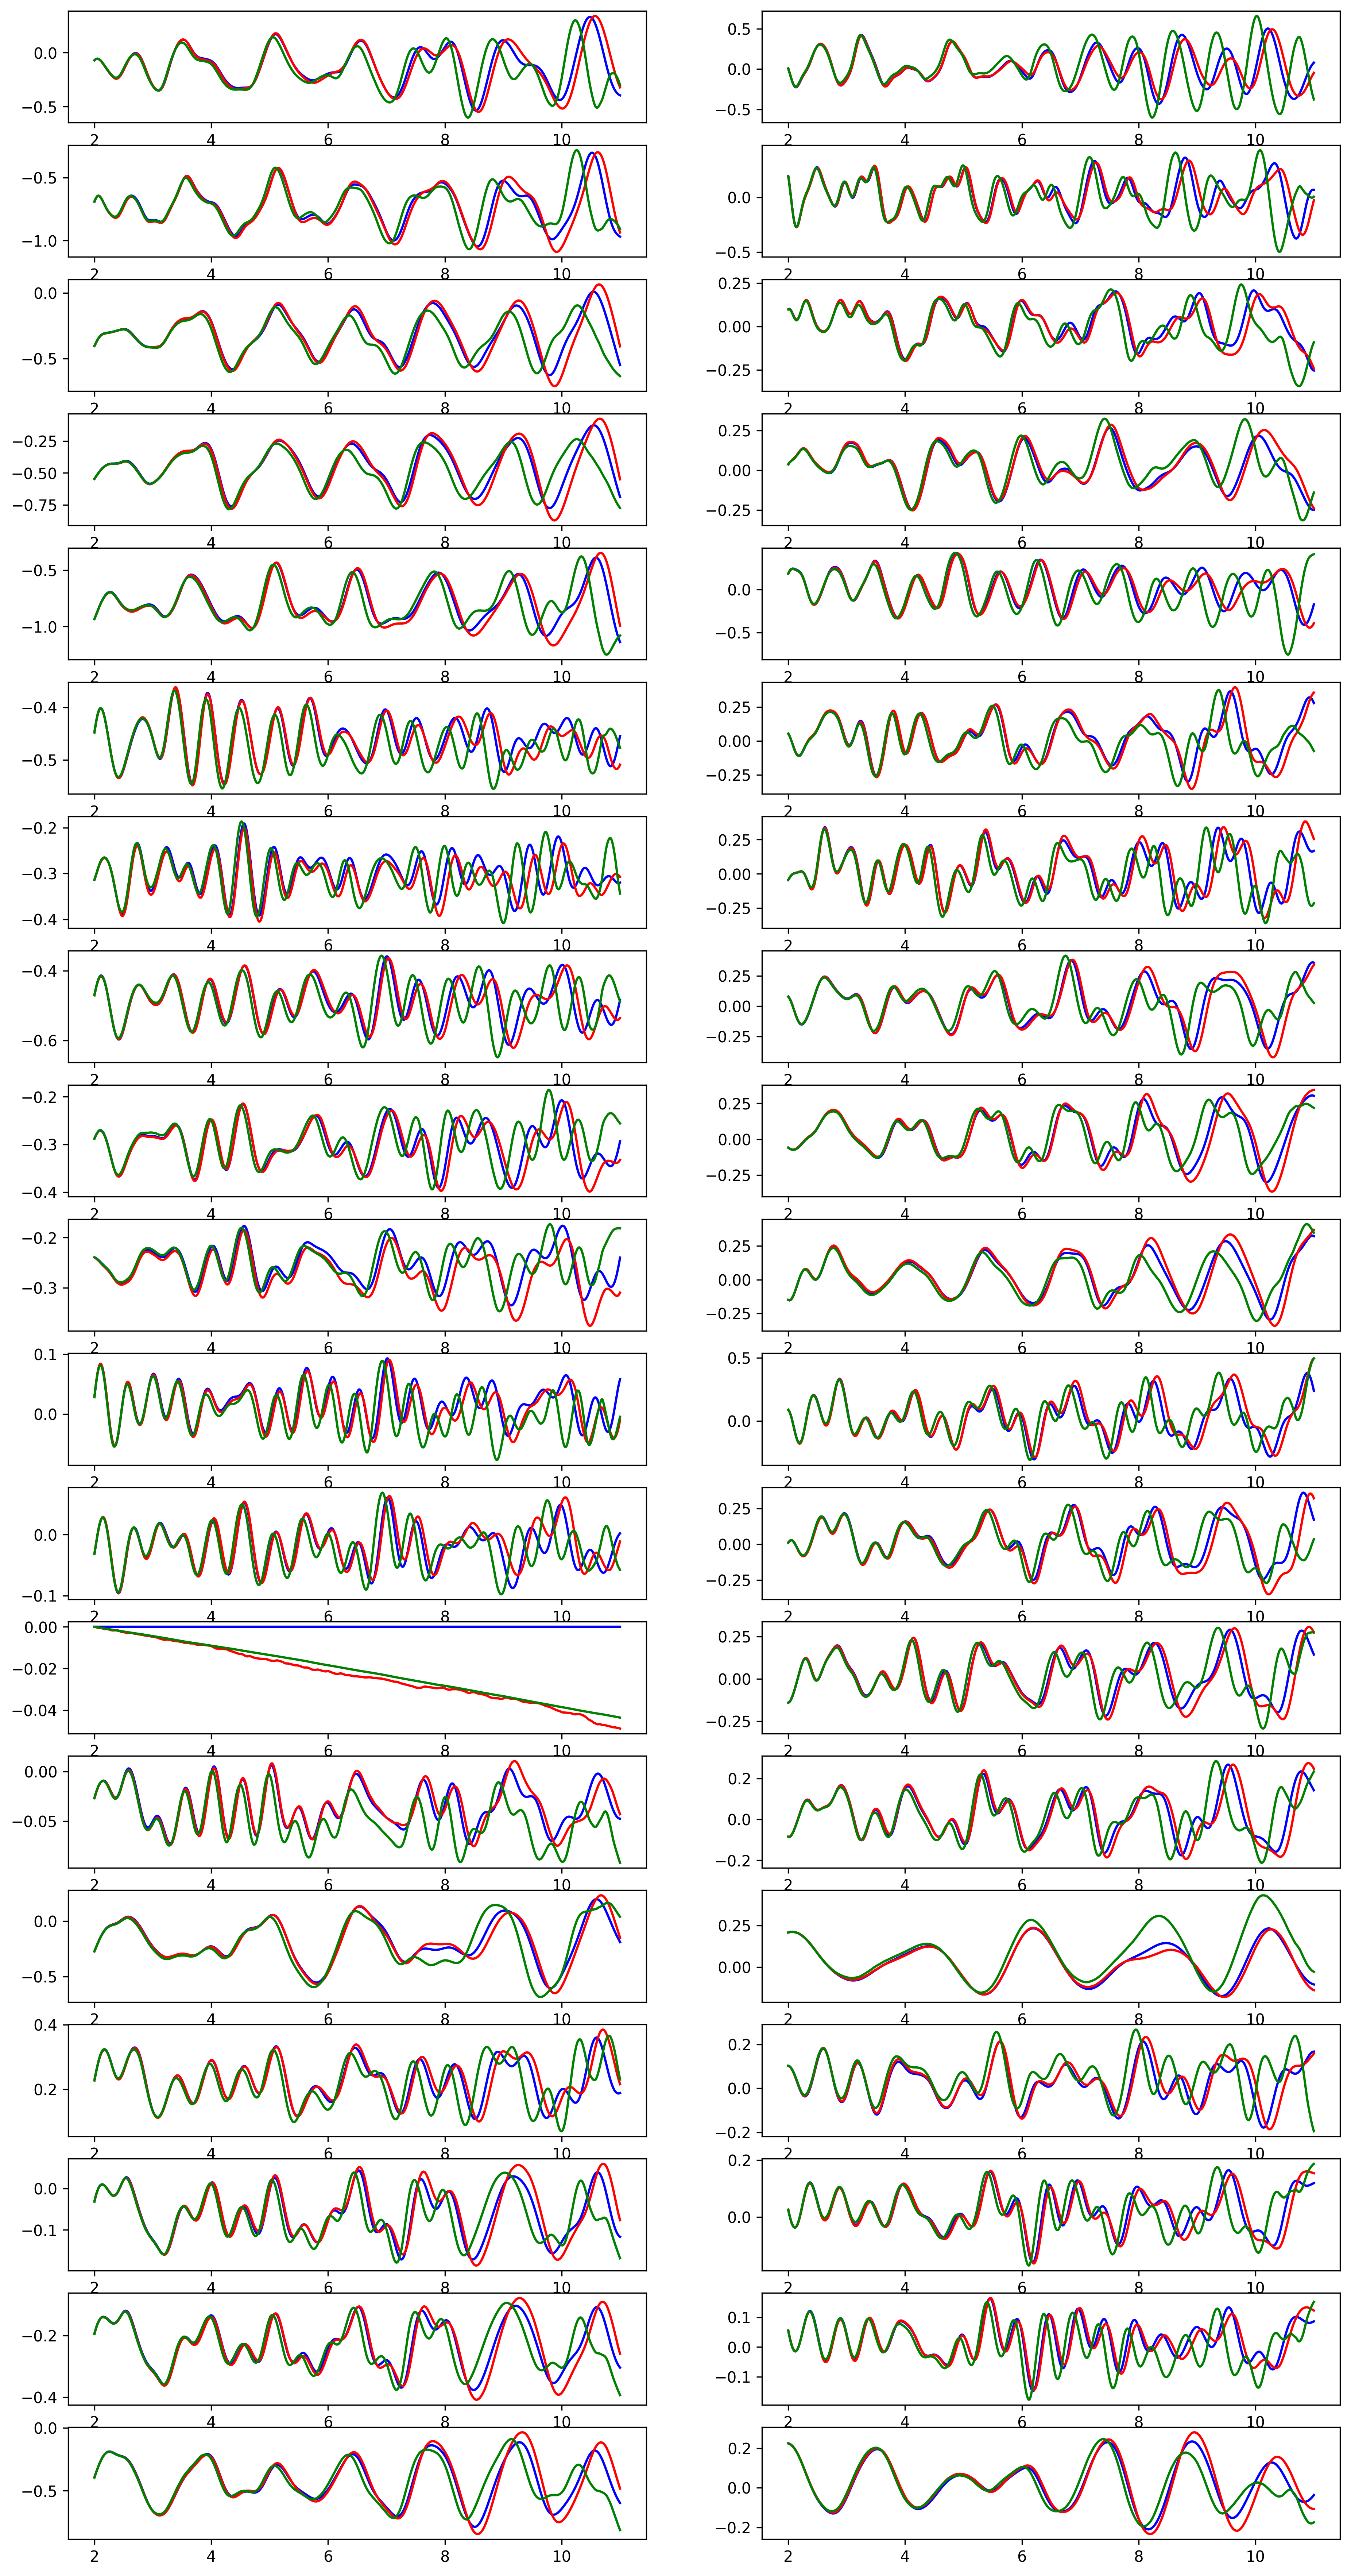

In [7]:
plt.figure(figsize=(15,30),dpi=300)
Generator_nodes = [10, 12, 25, 26, 31, 46, 49, 54, 59, 61, 65, 66, 69, 80, 87, 89, 100, 103, 111]
for i, node in enumerate(Generator_nodes):
    plt.subplot(19,2,2 * i + 1)
    plt.plot(t, x_test[:,2 * i], 'b', label="Rotor angle at node {}".format(node))
    plt.plot(t, x_test_hat_ode[:,2 * i],'r-', label="Estimated rotor angle at node {} using Neural ODE".format(node))
    plt.plot(t, x_test_hat_mlp[:,2 * i], 'g-', label="Estimated rotor angle at node {} using MLP".format(node))
    # plt.legend()
    plt.subplot(19,2,2 * i + 2)
    plt.plot(t, x_test[:,2 * i + 1], 'b', label="Rotor speed at node {}".format(node))
    plt.plot(t, x_test_hat_ode[:,2 * i + 1], 'r-', label="Estimated rotor speed at node {} using Neural ODE".format(node))
    plt.plot(t, x_test_hat_mlp[:,2 * i + 1], 'g-', label="Estimated rotor angle at node {} using MLP".format(node))
    # plt.legend()

In [9]:
x_test_hat_ode.shape, x_test.shape

(torch.Size([901, 38]), torch.Size([901, 38]))

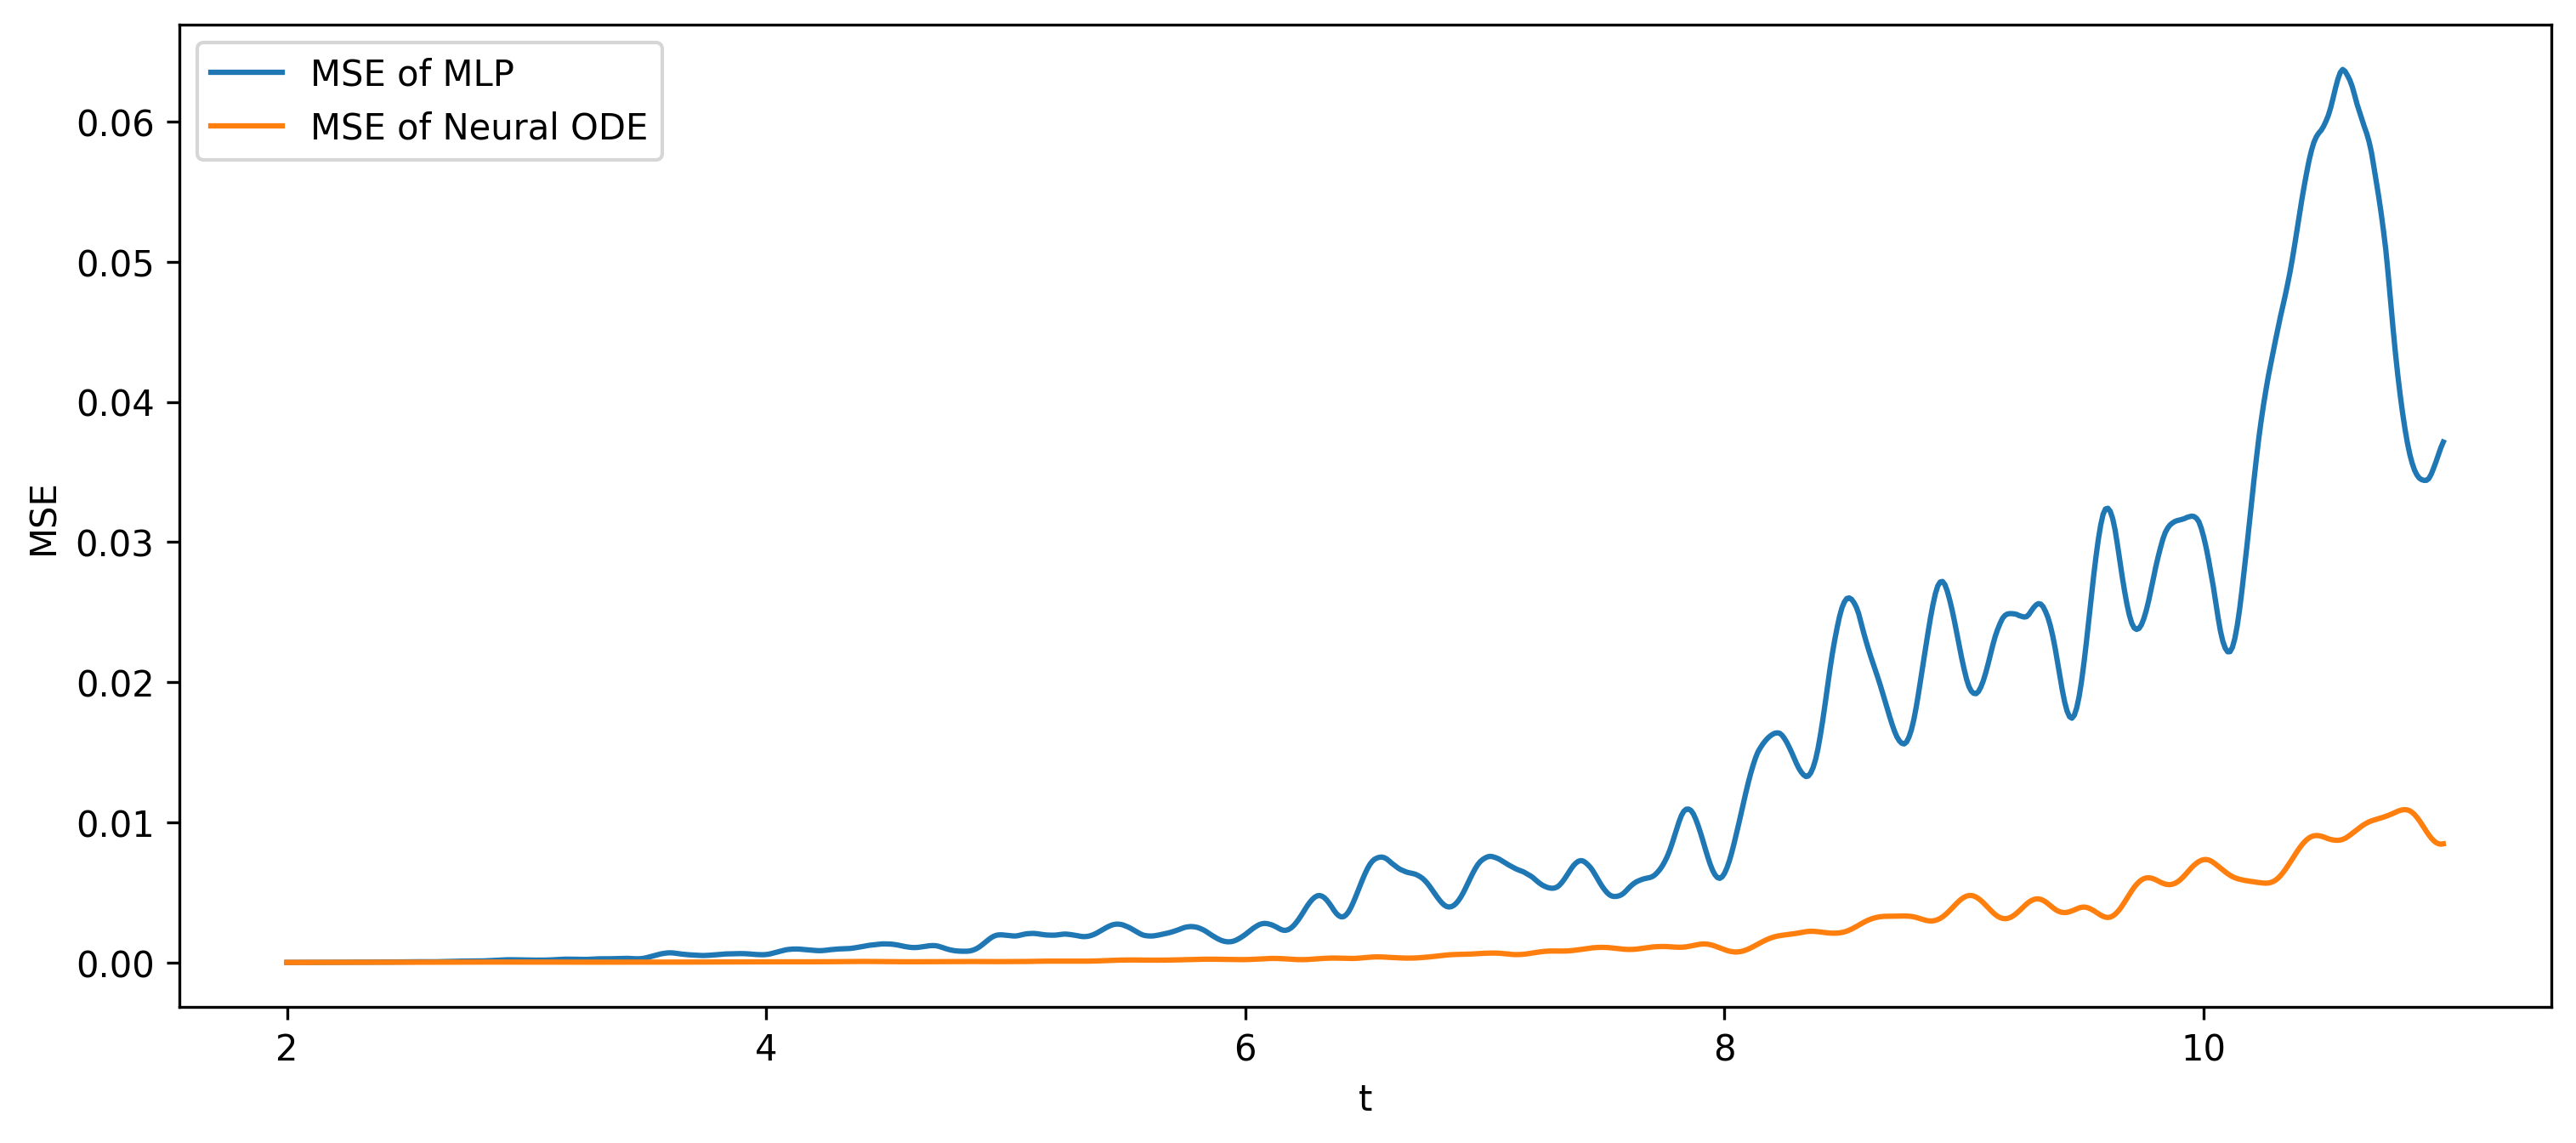

In [14]:
err_ode = torch.mean(torch.square(x_test_hat_ode - x_test), dim=1)
err_mlp = torch.mean(torch.square(x_test_hat_mlp - x_test), dim=1)

plt.figure(figsize=(12,5), dpi=300)
plt.plot(t, err_mlp, label = "MSE of MLP")
plt.plot(t, err_ode, label = "MSE of Neural ODE")
plt.xlabel("t")
plt.ylabel("MSE")
plt.legend()